### This jupyter notebook employs a fully connective neural network(FC) or its alias artificial neural network (ANN) to learn the mapping between input current configuration between output magnetic field 

In [41]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import torch
if torch.cuda.device_count():
    device = 'cuda'
    print('Good to go')
else:
    device = 'cpu'
    print('Using cpu')

Good to go


In [42]:
from ReadData import ReadCurrentAndField_CNN
import glob
import os 

# TODO zhoujing edit this Data loading 
# print(os.getcwd())
foldername="./Data/"
filepattern = "MagneticField[0-9]*.txt"
train_file_num= 1300
#data = ReadFolder(foldername,filepattern)
current,data = ReadCurrentAndField_CNN (foldername,filepattern,train_file_num)

fileList = glob.glob(foldername+filepattern)
position = data[:,0:3,2:18,2:18,2:18]
Bfield = data[:,3:,2:18,2:18,2:18]

# print(fileList)
print(data.shape)
print('current shape', current.shape)
print('Bfield shape', Bfield.shape)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [29]:
torch.set_printoptions(precision=10)
torch.set_printoptions(sci_mode=True)
print(data[2,:,0,0,0])

tensor([-5.0000000745e-02, -5.0000000745e-02, -5.0000000745e-02, 4.2985486798e-03,
        1.7197148874e-02, -1.9071470946e-02])


In [30]:
print(Bfield.shape)
print(Bfield.mean()*1e3)
print(Bfield.var())
print(Bfield.std()*1e3)

torch.Size([1300, 3, 16, 16, 16])
tensor(3.0549463630e-01)
tensor(2.1974647825e-04)
tensor(1.4823848724e+01)


In [44]:
#data normalization
#find min and max value of input position and Bfield
max_current, max_current_index = torch.max(current, dim=0, keepdim=True)
# print(max_current)
min_current, min_current_index = torch.min(current, dim=0, keepdim=True)
# print(min_current)

max_Bfield, max_Bfield_index = torch.max(Bfield.transpose(0,1).reshape(3,-1), dim=1, keepdim=True)
print(max_Bfield)
min_Bfield, min_Bfield_index = torch.min(Bfield.transpose(0,1).reshape(3,-1), dim=1, keepdim=True)
print(min_Bfield)

dimB = Bfield.shape
dimc = current.shape
print(min_current.shape)
print(min_Bfield.shape)

minB=min_Bfield.expand(3,int(Bfield.numel()/3)).reshape(3,dimB[0],dimB[2],dimB[3],dimB[4]).transpose(0,1)
maxB=max_Bfield.expand(3,int(Bfield.numel()/3)).reshape(3,dimB[0],dimB[2],dimB[3],dimB[4]).transpose(0,1)

ave_current=0.5*(max_current.expand(dimc[0],dimc[1])+min_current.expand(dimc[0],dimc[1]))
diff_current=0.5*(max_current.expand(dimc[0],dimc[1])-min_current.expand(dimc[0],dimc[1]))

current_norm = (current-ave_current)/diff_current
Bfield_norm = (Bfield-(minB+maxB)*0.5)/(0.5*(maxB-minB))

print(min_current.shape)
print(max_current.shape)
print(min_Bfield.shape)
print(max_Bfield.shape)

# torch.save(min_current, "./normalize_data/cnn_min_current.pt")
# torch.save(max_current, "./normalize_data/cnn_max_current.pt")
# torch.save(min_Bfield, "./normalize_data/cnn_min_Bfield.pt")
# torch.save(max_Bfield, "./normalize_data/cnn_max_Bfield.pt")


tensor([[5.0496105105e-02],
        [5.6420139968e-02],
        [5.1781326532e-02]])
tensor([[-5.2893340588e-02],
        [-5.3354568779e-02],
        [-6.1190709472e-02]])
torch.Size([1, 12])
torch.Size([3, 1])
torch.Size([1, 12])
torch.Size([1, 12])
torch.Size([3, 1])
torch.Size([3, 1])


In [33]:
from Neural_network import Generative_net, ResidualEMNSBlock_3d, BigBlock, weight_init, eMNS_Dataset
num_input = 12
output_shape = (3,16,16,16)
SB_args = (64,64,4,1) # (Cin, Cout, num_block)
BB_args = (2,2) # (scale_factor, num_block)
SB_block = ResidualEMNSBlock_3d 
BB_block = BigBlock

Generative_network = Generative_net(SB_args, BB_args, SB_block, BB_block, num_input=num_input, output_shape= output_shape)
print(Generative_network)

print(maxB.shape)
print(maxB[0,:].shape)

Generative_net(
  (proj): Linear(in_features=12, out_features=4096, bias=True)
  (conv3d): Conv3d(64, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (total_net): Sequential(
    (0): Linear(in_features=12, out_features=4096, bias=True)
    (1): Unflatten(dim=1, unflattened_size=(64, 4, 4, 4))
    (2): BigBlock(
      (block): Sequential(
        (0): ResidualEMNSBlock_3d(
          (block): Sequential(
            (0): Sequential(
              (0): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
              (2): LeakyReLU(negative_slope=0.01)
            )
            (1): Sequential(
              (0): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
              (2): LeakyReLU(negative_slope=0.01)
            )
    

In [34]:
MaxB=maxB.cuda(0)
MinB=minB.cuda(0)
print(MaxB.device)
print(MinB.device)

cuda:0
cuda:0


In [35]:
from Neural_network import Generative_net, ResidualEMNSBlock_3d, BigBlock, weight_init, eMNS_Dataset,Generative_net_test
from Training_loop import train_part_GM,get_mean_of_dataloader
from tqdm import tqdm

batch_size = 32
# construct dataset
dataset = eMNS_Dataset(
    train_x=current_norm,
    train_y=Bfield_norm
)
###############################################
# Config the neural network
###############################################
num_input = 12
output_shape = (3,16,16,16)
SB_args = (64,64,4,1) # (Cin, Cout, num_repeat, num_block)
BB_args = (2,2) # (scale_factor, num_block)
SB_block = ResidualEMNSBlock_3d 
BB_block = BigBlock
DF = False # whether using divergence free model

Generative_network = Generative_net(SB_args, BB_args, SB_block, BB_block, num_input=num_input, output_shape= output_shape)
epochs = 400
learning_rate_decay = .5
learning_rates = [0.5e-4]
RMSE_lr = []
schedule = []
linear_lr = False
weight_decays = [0]

train_percents = np.arange(1.0,1.01,0.1)
RMSE_history_end = np.zeros(len(train_percents))
RMSE_val_history_end = np.zeros(len(train_percents))
loss_history_end = np.zeros(len(train_percents))
iter_history_end = np.zeros(len(train_percents))
mse_history_end = np.zeros(len(train_percents))
mse_val_history_end = np.zeros(len(train_percents))
train_stop_epoch = np.zeros(len(train_percents))


################################################
# Train the neural network
################################################
index=0
for train_percent in train_percents:
    epoch_stop = 0
    print('train_percent',train_percent)
    for learning_rate in tqdm(learning_rates):
        for weight_decay in weight_decays:

            # split the dataset to train, validation, test
            train_set, valid_set = torch.utils.data.random_split(dataset, [0.9,0.1])

            #Using Dataloader for batch train
            train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,shuffle=True)
            valid_loader = torch.utils.data.DataLoader(dataset=valid_set,batch_size=batch_size,shuffle=True)

            get_mean_of_dataloader(valid_loader,model=Generative_network,device=device)
            print("----------------------------")
            
            print("----------------------------")
            # test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,shuffle=True)

            Generative_network.apply(weight_init)
            optimizer = torch.optim.Adam([{'params':Generative_network.parameters()}], lr=learning_rate, weight_decay= weight_decay, betas=(0.5,0.99))
            RMSE_history, RMSE_val_history, loss_history, iter_history, mse_history, mse_val_history,epoch_stop,Rsquare,loss_train,loss_val= train_part_GM(
                model=Generative_network, optimizer=optimizer, train_loader=train_loader, valid_loader=valid_loader, epochs=epochs, 
                learning_rate_decay=learning_rate_decay, weight_decay=weight_decay, schedule=schedule, grid_space= dimB[2]*dimB[3]*dimB[4], DF=DF,verbose=False, device=device, maxB=MaxB[0,:], minB=MinB[0,:],
                lr_max=learning_rate, lr_min=0.25e-6,max_epoch=epochs, linear_lr=linear_lr)
        
        
        RMSE_lr.append(RMSE_val_history[epoch_stop].item())
    
    #save RMSE and loss after early stopping
    RMSE_history_end[index] = RMSE_history[epoch_stop]
    RMSE_val_history_end[index]= RMSE_val_history[epoch_stop]
    loss_history_end[index] = loss_history[epoch_stop]
    iter_history_end[index] = iter_history[epoch_stop]
    mse_history_end[index] = mse_history[epoch_stop]
    mse_val_history_end[index] = mse_val_history[epoch_stop]
    index=index+1
    print('training stop at epoch:',epoch_stop)
    print('training stop at epoch:',Rsquare)

train_percent 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

----------------------------
----------------------------
epoch================================================= 0
Epoch 0, Iteration 37, loss = 0.3115
Got rmse 16.03308868408203
Got rmse 16.01628303527832

epoch================================================= 1
Epoch 1, Iteration 74, loss = 0.1922
Got rmse 13.987354278564453
Got rmse 13.110097885131836

epoch================================================= 2
Epoch 2, Iteration 111, loss = 0.1685
Got rmse 9.07283878326416
Got rmse 8.913055419921875

epoch================================================= 3
Epoch 3, Iteration 148, loss = 0.1353
Got rmse 8.609114646911621
Got rmse 8.122292518615723

epoch================================================= 4
Epoch 4, Iteration 185, loss = 0.1711
Got rmse 7.2233405113220215
Got rmse 6.870331287384033

epoch================================================= 5
Epoch 5, Iteration 222, loss = 0.1258
Got rmse 5.813088893890381
Got rmse 5.718806266784668

epoch=====================================

100%|██████████| 1/1 [16:10<00:00, 970.66s/it]

Got rmse 0.7581966519355774

training stop at epoch: 399
training stop at epoch: tensor(9.9227845669e-01, device='cuda:0')


In [40]:
torch.save(Generative_network, 'EMS_CNN.pt')	# 这里会存储迄今最优模型的参数

In [37]:
print(loss_val.shape)
print(loss_train.shape)

torch.Size([400])
torch.Size([400])


[1.3204164505004883]
[5e-05]
1.3204164505004883 5e-05


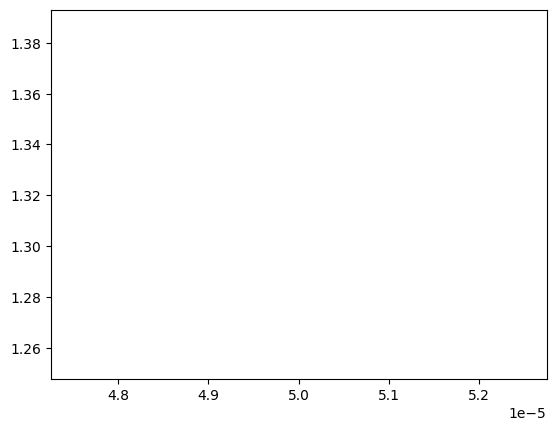

In [38]:
print(RMSE_lr)
print(learning_rates)
print(RMSE_lr[0],learning_rates[0])
import matplotlib.pyplot as plt 
plt.plot(learning_rates,RMSE_lr)

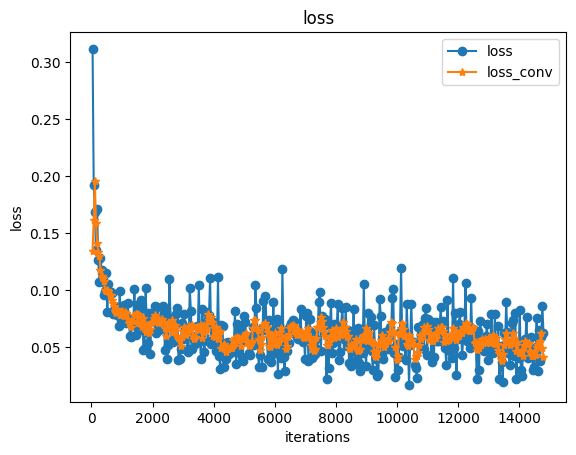

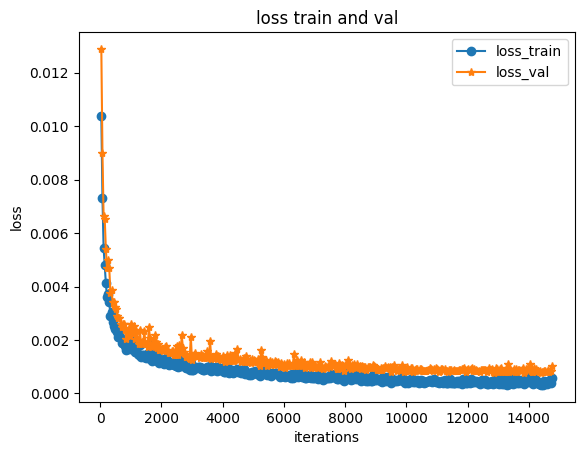

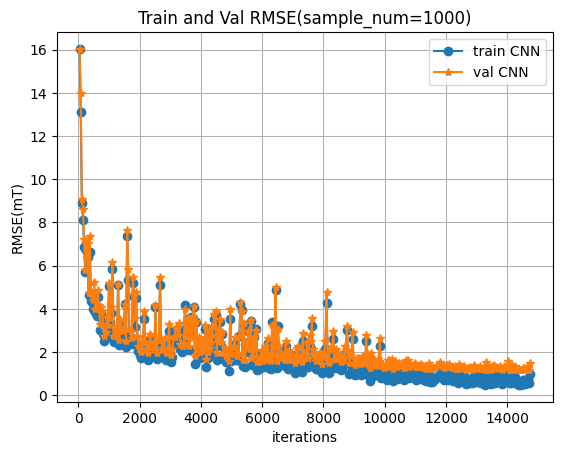

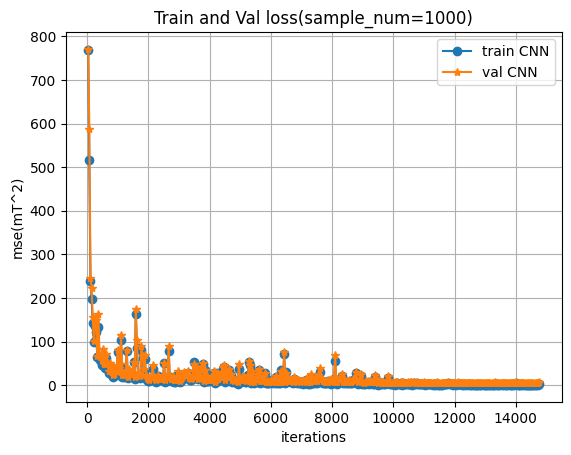

In [39]:
import matplotlib.pyplot as plt
import numpy as np
ave_site = 5
ave_kernel = 1/ave_site*np.ones(ave_site)
loss_history_conv = np.convolve(loss_history.numpy(),ave_kernel,'same')


plt.title('loss')
plt.plot(iter_history,loss_history,'-o')
plt.plot(iter_history,loss_history_conv,'-*')
plt.legend(['loss','loss_conv'])
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()



plt.title('loss train and val')
plt.plot(iter_history[0:epoch_stop],loss_train[0:epoch_stop],'-o')
plt.plot(iter_history[0:epoch_stop],loss_val[0:epoch_stop],'-*')
plt.legend(['loss_train','loss_val'])
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()


plt.title('Train and Val RMSE(sample_num=1000)')
plt.plot(iter_history[0:epoch_stop],RMSE_history[0:epoch_stop],'-o')
plt.plot(iter_history[0:epoch_stop],RMSE_val_history[0:epoch_stop],'-*')
# plt.plot(2e-5*np.arange(epoch_stop),RMSE_history[0:epoch_stop]*1000,'-o')
# plt.plot(2e-5*np.arange(epoch_stop),RMSE_val_history[0:epoch_stop]*1000,'-*')
# plt.ylim([15,20])
plt.legend(['train CNN','val CNN'])
plt.xlabel('iterations')
plt.ylabel('RMSE(mT)')
# plt.ylim([0,100])
plt.grid()
plt.show()

plt.title('Train and Val loss(sample_num=1000)')
plt.plot(iter_history[0:epoch_stop],mse_history[0:epoch_stop],'-o')
plt.plot(iter_history[0:epoch_stop],mse_val_history[0:epoch_stop],'-*')
plt.legend(['train CNN','val CNN'])
plt.xlabel('iterations')
plt.ylabel('mse(mT^2)')
plt.grid()
plt.show()

In [ ]:
print(epoch_stop)

In [ ]:
print(position[0:1,:].shape)

In [ ]:
import torch 
# a = torch.range(1,48).reshape(3,4,4)
a = torch.randn(3,4,4)
b = a+1
grad_a = torch.gradient(a)
grad_a_x = torch.gradient(a[0])
grad_a_y = torch.gradient(a[1])
grad_a_z = torch.gradient(a[2])
print(len(a))
print(grad_a[2])
print(grad_a_z)
error = torch.sum(grad_a[1] + grad_a[2]) - torch.sum(sum(grad_a_x)+sum(grad_a_y) +sum(grad_a_z))
print(error)
print(a[1].shape)

In [ ]:
print(Generative_net)

In [ ]:
from torchviz import make_dot
import torch.nn.functional as F
from Training_loop import grad_loss
x = torch.randn(2,12)
y = Bfield[0:2]
preds = Generative_network(x)
print(preds.shape)
loss =   grad_loss(preds,y)
        # optimizer.zero_grad() #zero out all of gradient
loss.backward()

make_dot(loss, params=dict(Generative_network.named_parameters()))